#### Load required libraries

In [1]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SH_AcO'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

In [22]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [11]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

In [4]:
with open(Path(sim_folder)/'AcO_controller.yaml','r') as stream:
        aco_ctrl_dt = yaml.safe_load(stream)
aco_ctrl_dt['System']['parameters']['num'] = [-0.15]
with open(Path(sim_folder)/'AcO_controller.yaml','w') as f:
        y.dump(aco_ctrl_dt, f)

#### AcO reconstructor+controller settings

In [2]:
n_bm = 27

In [15]:
from scipy.linalg import block_diag

# Reconstructor settings
dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)
    
# Compute AcO reconstructor using decoupled strategy
w_M1TxyzRxyz = np.diag(np.array([1,1,1,1,1,1]))#np.diag(np.array([1,1,1,4,4,4]))
w_M2TxyzRxyz = np.diag(np.array([1]*6))#np.diag(np.array([50,40,40,1,1,1]))          
w_M1BM = np.eye(n_bm)
W2 = block_diag(w_M1TxyzRxyz, w_M2TxyzRxyz, w_M1BM)

W2_coeff = 0.01/np.trace(W2)
print('Weighting factor of W2:',W2_coeff)
W2 = W2_coeff*W2
            

# MPC settings

# Plant dynamic model matrices
A = np.zeros((84+7*n_bm,84+7*n_bm))
B = np.identity(84+7*n_bm)
nx, nu = A.shape[0], B.shape[1]

# Prediction horizon
npred = 2
# Weighting matrices
Q = np.eye(nx)
R = 5*np.kron(np.eye(7),block_diag(w_M1TxyzRxyz, w_M2TxyzRxyz, w_M1BM))
print(np.linalg.norm(Q),np.linalg.norm(R))

# Controller output constraints
range_m1Txyz = [3.0e-3,4.75e-3,4e-3]
range_m1Rxyz = [6.5e-4,5.75e-4,5.75e-4]
range_m2Txyz = [3.0e-5,3.0e-5,3.0e-5]
range_m2Rxyz = [3.5e-3,3.5e-3,3.5e-3]
range_m1BM = [1.0e-3]*n_bm
range_seg = np.array(range_m1Txyz+range_m1Rxyz+range_m2Txyz+range_m2Rxyz+range_m1BM)

umax = np.kron(np.array([1]*7),range_seg) #np.array([])
umin = -umax
dumin, dumax = np.array([]), np.array([]) #2*umin, 2*umax

# MPC dictionary
data = {'SHAcO':{'D':dt['calibdt'][()]['D'],'W2':W2,'n_bm':n_bm,
                       'wfsMask':dt['calibdt'][()]['wfsMask'],
                       'A':A,'B':B,
                       'Q':sparse.csc_matrix(Q),'R':sparse.csc_matrix(R),
                       'npred':npred,'dumin':dumin,'dumax':dumax,
                       'umin':umin,'umax':umax}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO.pickle','wb') as f:
    pickle.dump(data,f)
    
# dictionary for debug
data = {'SHAcO_debug':{'D':dt['calibdt'][()]['D'],'W2':W2,'n_bm':n_bm,
                       'wfsMask':dt['calibdt'][()]['wfsMask'],
                       'A':A,'B':B,
                       'Q':sparse.csc_matrix(Q),'R':sparse.csc_matrix(R),
                       'npred':npred,'dumin':dumin,'dumax':dumax,
                       'umin':umin,'umax':umax}}
# Pickles MPC data into string representation
with open(Path(sim_folder)/'SHAcO_debug.pickle','wb') as f:
    pickle.dump(data,f)

Weighting factor of W2: 0.0002564102564102564
16.522711641858304 82.61355820929153


#### Set initial M1/M2 states and generate respective yaml files

In [16]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML

#test_case = 's1_curvature_error'
test_case = 'BM_dist'

if 'm1_x0_dt' in locals():
    del m1_x0_dt
if 'm2_x0_dt' in locals():
    del m2_x0_dt    

if(test_case == 's1_curvature_error'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
#        
elif(test_case == 'fully_aligned'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
#        
elif(test_case == 'BM_dist'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m1_x0_dt['state']['modes'][0][2] = 5.0e-4
    m1_x0_dt['state']['modes'][0][0] = 0*5.0e-4
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
    
# Update number of M1 bending modes in yaml file
m1_x0_dt['mirror_args']['N_MODE'] = n_bm
    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)        

#### Instantiate DOS

In [17]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SH_AcO/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: SHAcO
INFO:SHAcO:New input: wfs48 data
INFO:SHAcO:New output: M1 Txyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M1 Rxyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M2 Txyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M2 Rxyz
INFO:SHAcO:Output logged in!
INFO:SHAcO:New output: M1 BM
INFO:SHAcO:Output logged in!
INFO:DOS:New driver: SHAcO_debug
INFO:SHAcO_debug:New input: wfs48 data
INFO:SHAcO_debug:New output: x_hat
INFO:SHAcO_debug:Output logged in!
INFO:DOS:New driver: science
INFO:science:No inputs!
INFO:science:New output: wfe_rms
INFO:science:Output l

SIMCEO server received: Acknowledging connection from SIMCEO client!
27 BMs used in the reconstructor computation.
No reconstructor matrix row reordering!
Absolute constraints introduced to MPC
27 BMs used in the reconstructor computation.


INFO:DOS:Simulation setup for a duration of 35s @ 1Hz (35 steps)!


No reconstructor matrix row reordering!
Dimension of Dsh: (7360, 273)


In [18]:
# Start simulation
#sim.start()
sim._run_()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP6
INFO:science:OP7
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None
INFO:DOS:Running
/Users/rromano/Workspace/SIMCEO/dos/sh_aco_driver.py:162: RuntimeWarning: invalid value encountered in double_scalars
  print('->',J1,J3,J1/J3)


-> 0.0 0.0 nan
d>: 0.0 1 0.0
d>: 1.5741884624731108e-11 4.4712455038648846e-11 0.3520693420015527
d>: 1.6891545694680253e-11 5.789959450664338e-11 0.29173858363968547
d>: 8.408189358031678e-12 4.8805073387206834e-11 0.17228105142519257
d>: 6.807907144175093e-12 3.715140659135625e-11 0.1832476282542433
d>: 5.520833883443125e-12 2.923303496480708e-11 0.18885599425750763
d>: 4.813388299067358e-12 2.476200568336744e-11 0.19438604290041397
d>: 4.40425368317686e-12 2.245512617620697e-11 0.19613577980441385
d>: 4.204848081873101e-12 2.1443221810067322e-11 0.19609217864355524
d>: 4.1292287579214275e-12 2.1168263203463672e-11 0.19506696029959508
d>: 4.1203639286950565e-12 2.129666756084745e-11 0.1934745854919612
d>: 4.145750138956653e-12 2.1639496693044173e-11 0.19158255840068908
d>: 4.187504927374827e-12 2.20934445843254e-11 0.1895360821347763
d>: 4.235902997600666e-12 2.2603740782610236e-11 0.18739831775364718
d>: 4.2858363457778886e-12 2.314238425653111e-11 0.18519424352606903
Constraint vio

INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


Elapsed time: 19.398241758346558


In [6]:
sim.pctComplete

100

### Image quality metrics

In [50]:
sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]

array([5.59843193e-06, 7.71736230e-10, 7.71736453e-10, 7.71906428e-10,
       7.71736397e-10, 7.71736175e-10, 1.72432388e-10])

 #### MPC w/o saturation


Final values:
 WFE: [43.6330474] 
 [1.95069716 0.77163154 0.77172302 0.77207751 0.77225093 0.77275691
 0.17243397] 
PSSn: [0.99999975] 
sum of abs seg piston: 0.12582886017940137 
 [ 1.23759591e-01 -1.00698486e-05 -1.86964846e-04  2.17072096e-04
 -9.30772182e-04  2.53816995e-04  4.70573192e-04]



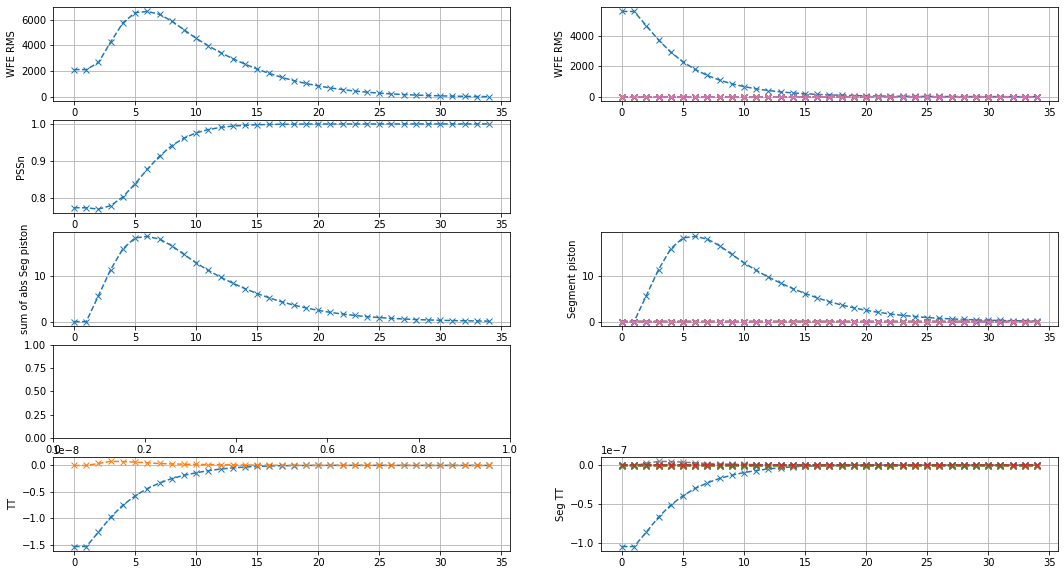

In [67]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### MPC w/o saturation


Final values:
 WFE: [1232065.26041031] 
 [7.21399731e+05 7.71715747e-01 7.71732622e-01 7.72091113e-01
 7.72244213e-01 7.72778230e-01 1.72434331e-01] 
PSSn: [0.7975352] 
sum of abs seg piston: 3446.1638427702114 
 [ 3.44616175e+03 -2.00184955e-05 -2.55823224e-04  2.04798470e-04
 -8.21134993e-04  3.23459232e-04  4.70557038e-04]



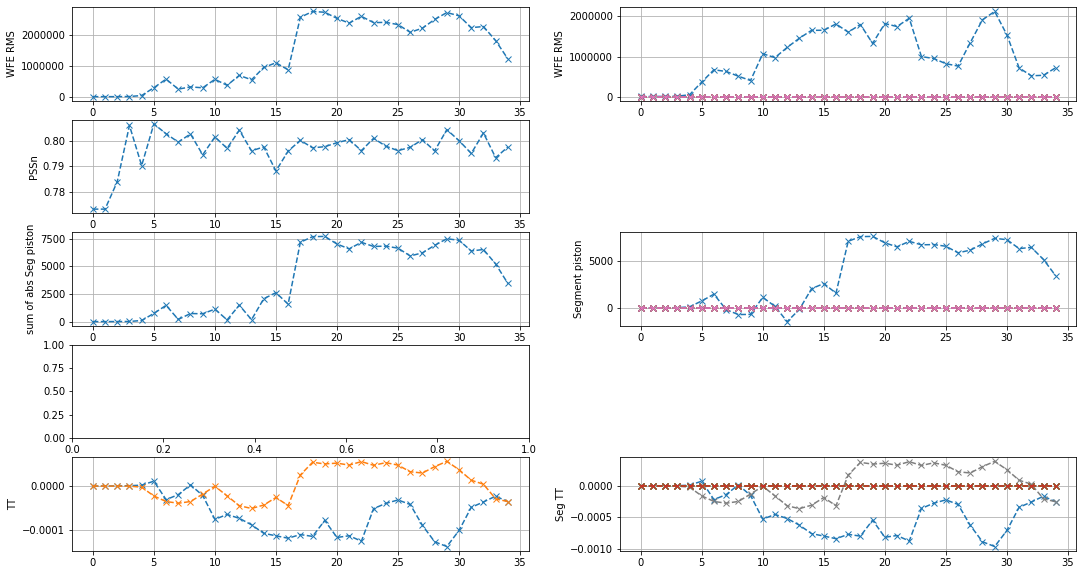

In [8]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Regularized reconstructor & MPC with saturation


Final values:
 WFE: [77338.56909908] 
 [1.11516624e+03 7.71561814e-01 7.72052089e-01 7.72015951e-01
 7.71943787e-01 7.71864017e-01 1.72443990e-01] 
PSSn: [0.97891844] 
sum of abs seg piston: 219.49907177204636 
 [-2.19497379e+02  1.37683909e-05 -2.74845979e-04 -1.37094128e-04
 -2.64025107e-04 -5.34352118e-04  4.69120021e-04]



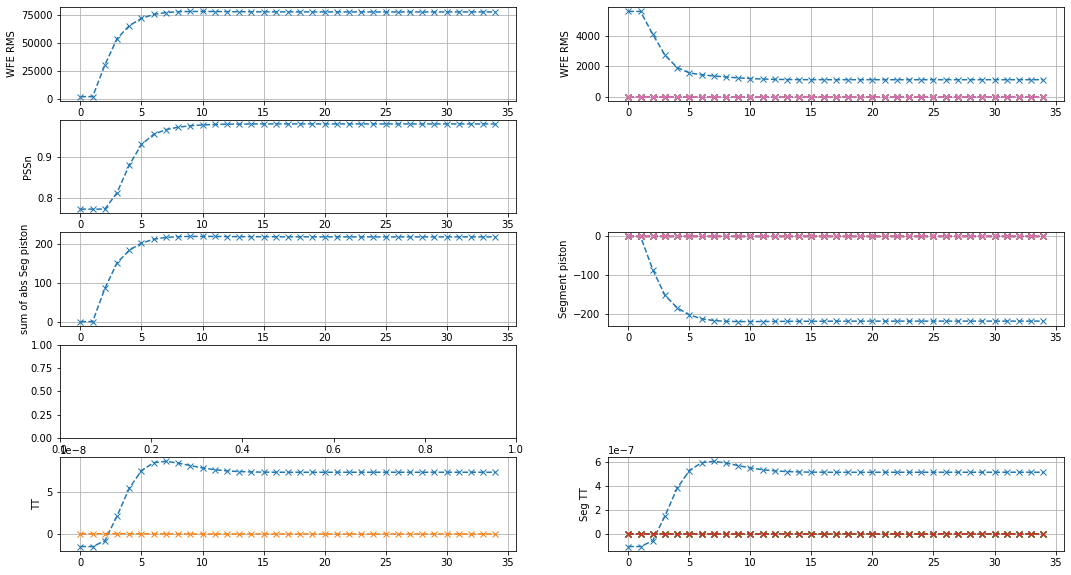

In [19]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Integral controller w/o saturation


Final values:
 WFE: [118.16942447] 
 [5.74445425 0.7716553  0.77171752 0.77208362 0.77220119 0.77268425
 0.17243268] 
PSSn: [0.99999807] 
sum of abs seg piston: 0.3373056928004936 
 [ 3.35289201e-01 -8.18711973e-05 -1.60973165e-04  1.55069041e-04
 -8.32561853e-04  3.15203530e-04  4.70813166e-04]



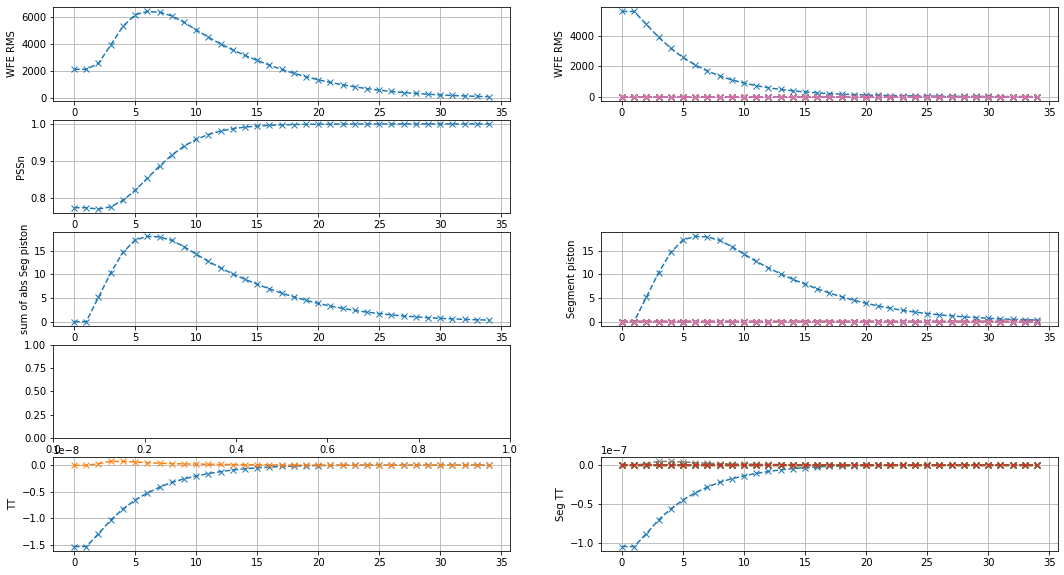

In [7]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

 #### Integral controller with saturation


Final values:
 WFE: [1306231.01722449] 
 [1.03464839e+06 7.71665787e-01 7.71757935e-01 7.72124753e-01
 7.72284126e-01 7.72723219e-01 1.72434261e-01] 
PSSn: [0.79414207] 
sum of abs seg piston: 3574.4811716135055 
 [ 3.57447891e+03  6.81676521e-05 -2.83685020e-04  8.37756253e-05
 -8.90270913e-04  4.69451145e-04  4.70615158e-04]



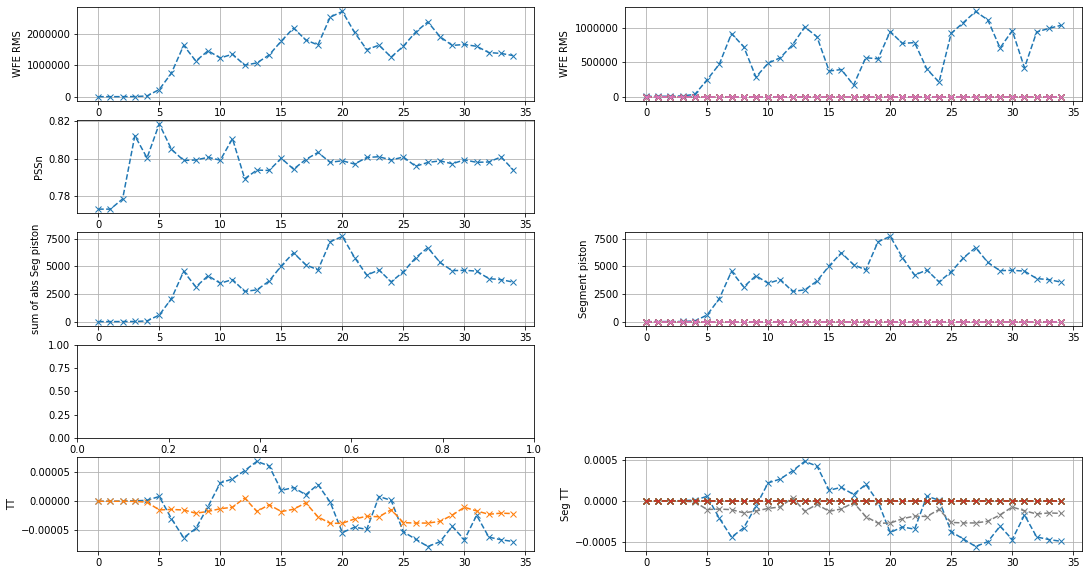

In [7]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

### Controller outputs and aberration inducing loads

 #### MPC w/o saturation

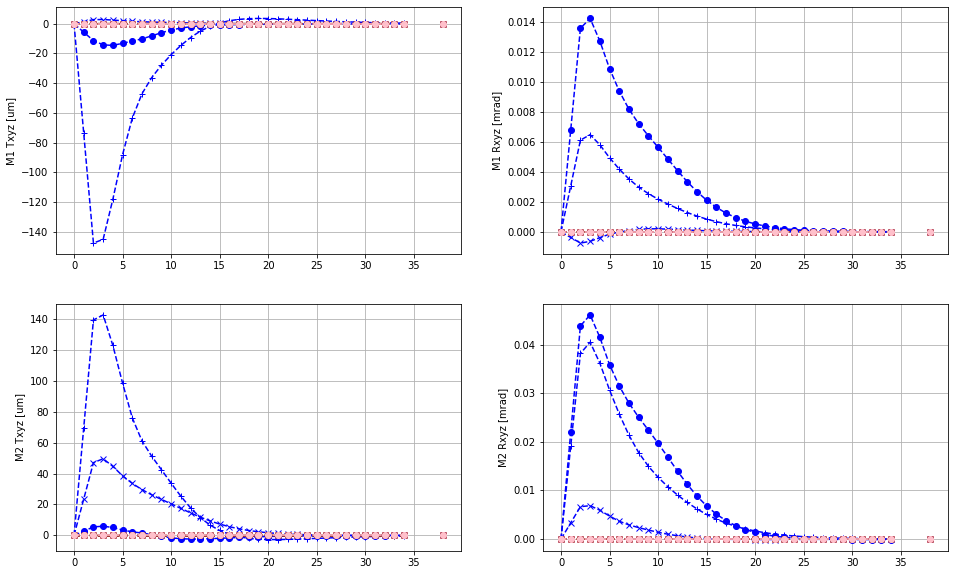

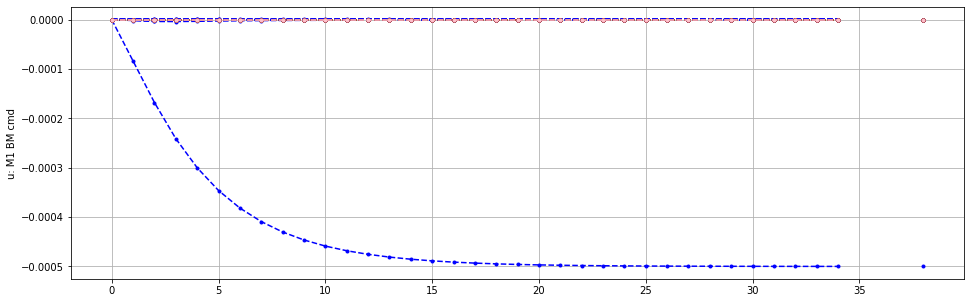

In [68]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### MPC with saturation

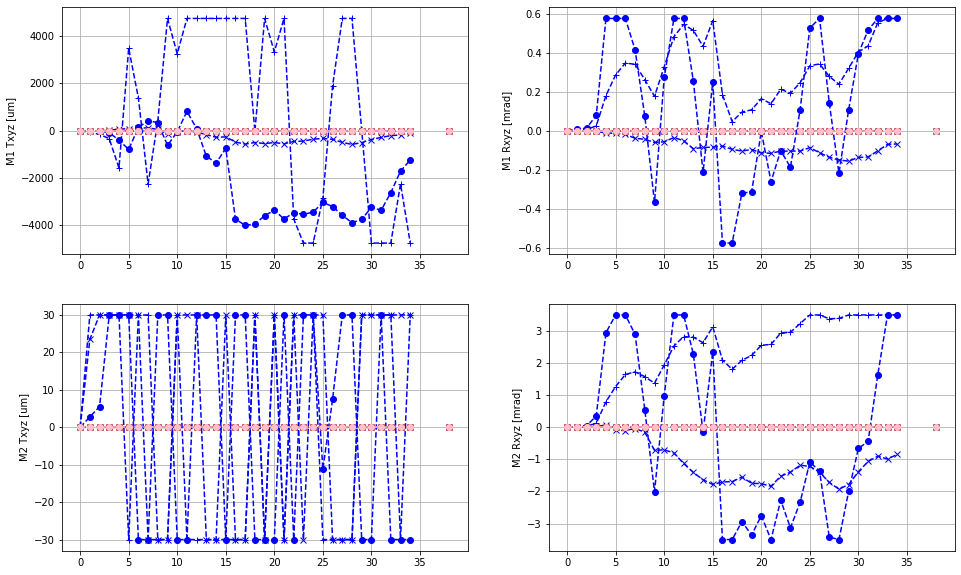

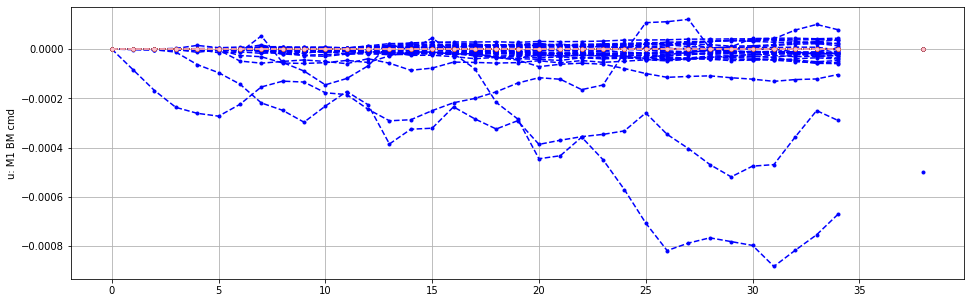

In [7]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### Regularized reconstructor & MPC with saturation

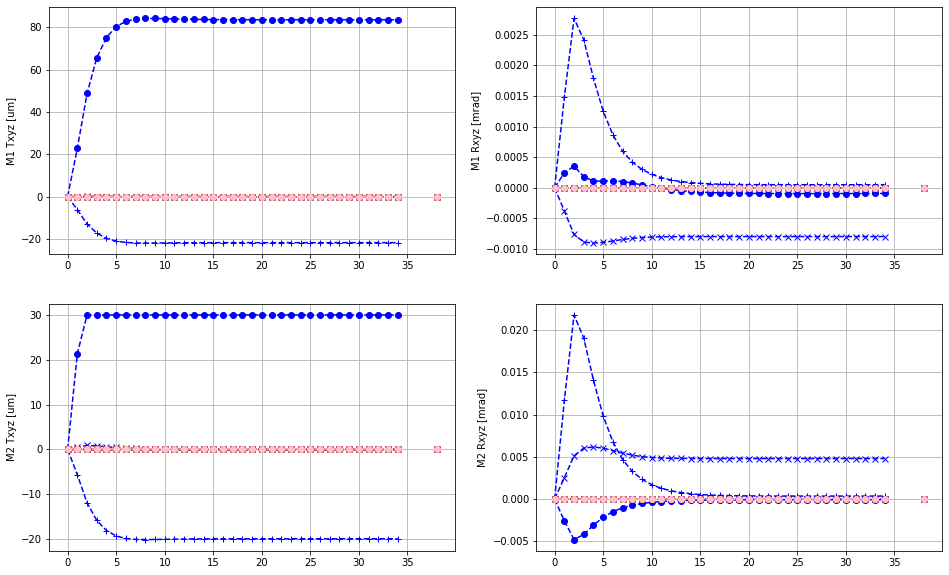

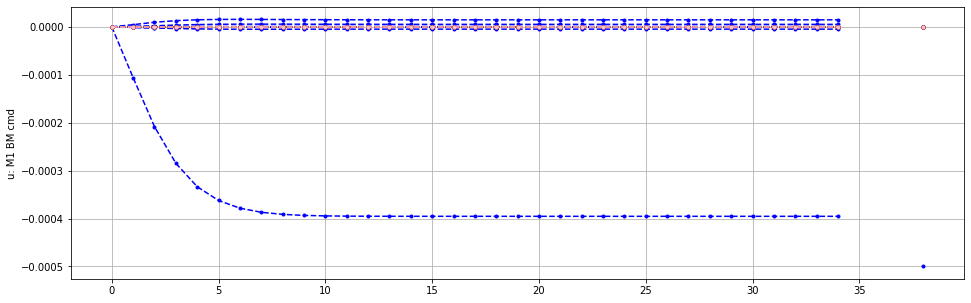

In [20]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

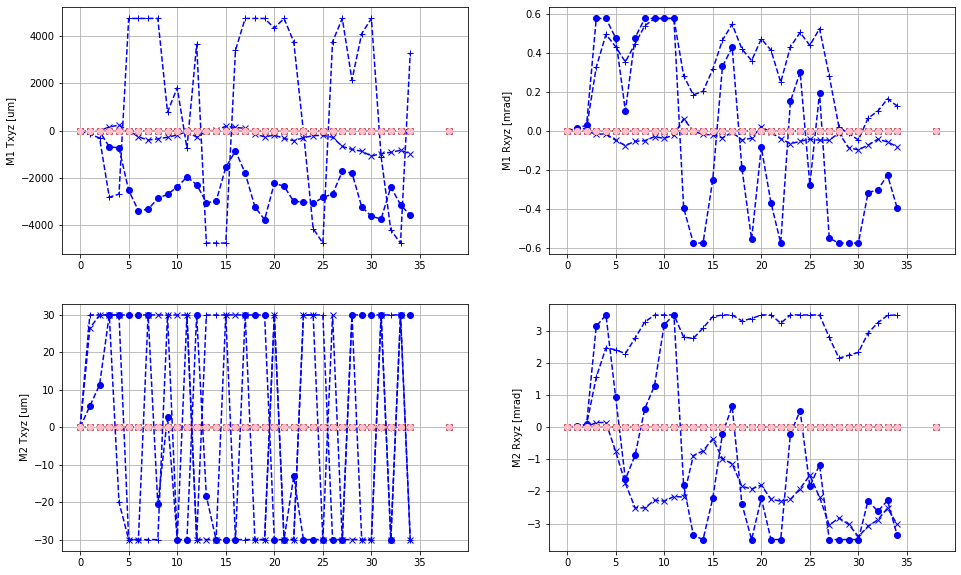

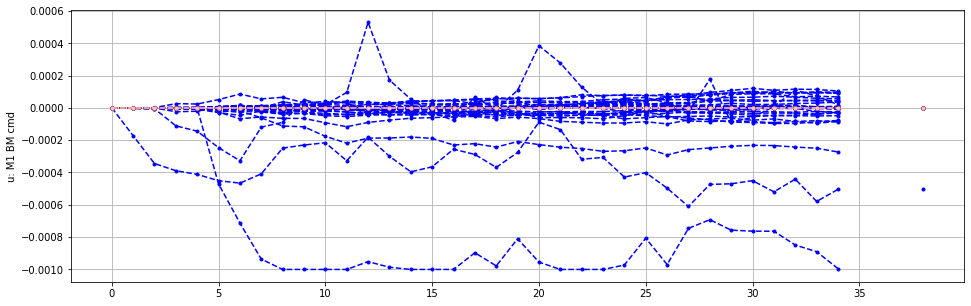

In [7]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### I-controller w/o saturation

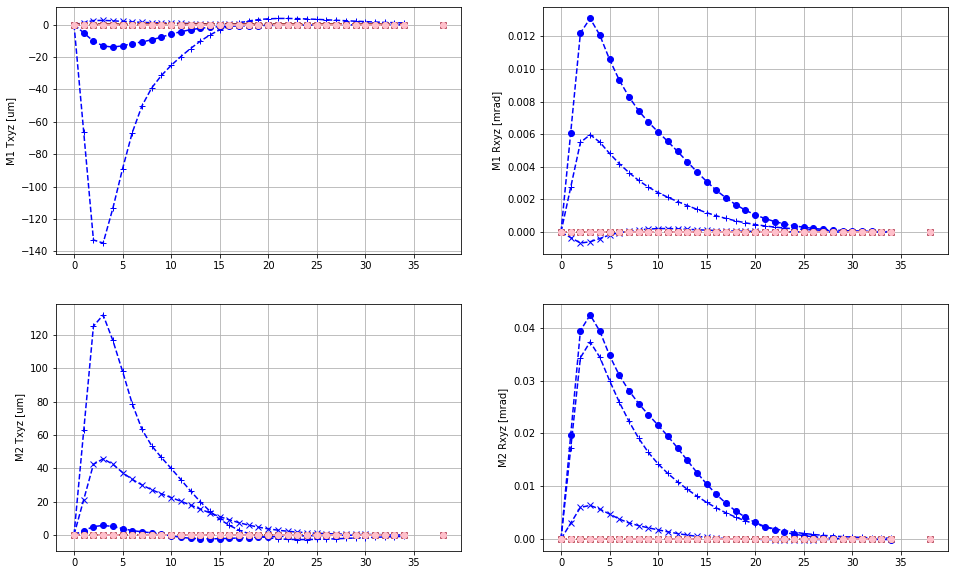

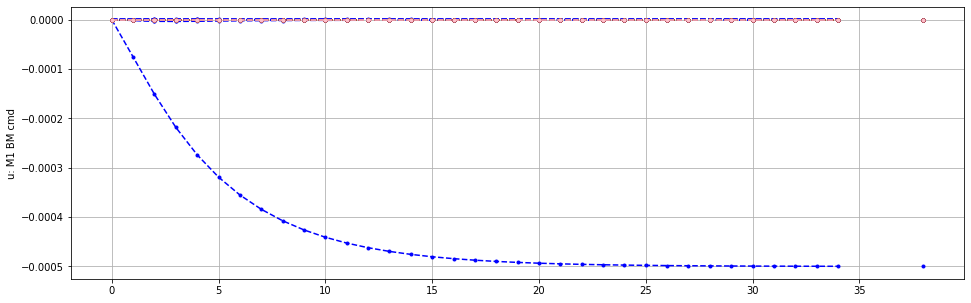

In [8]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

 #### I-controller with saturation

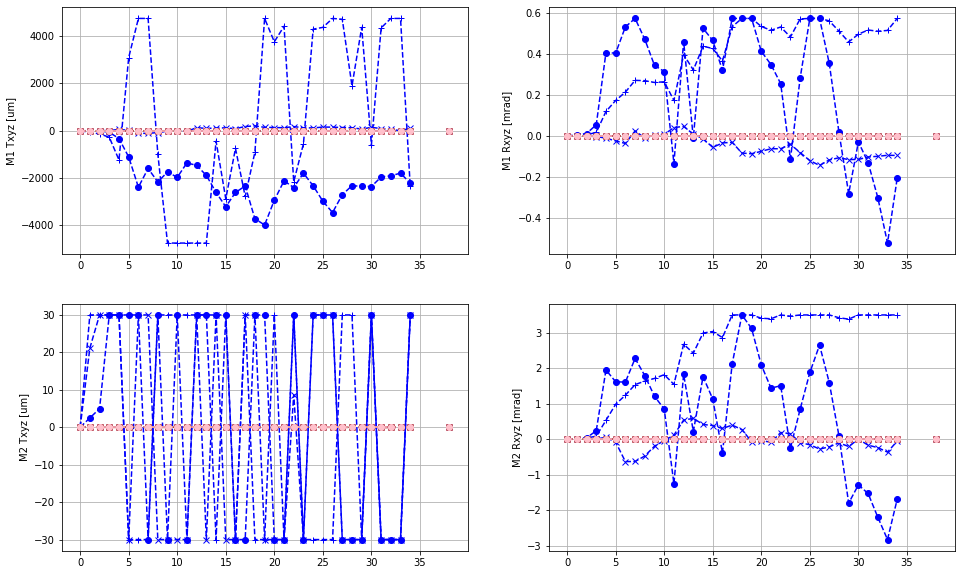

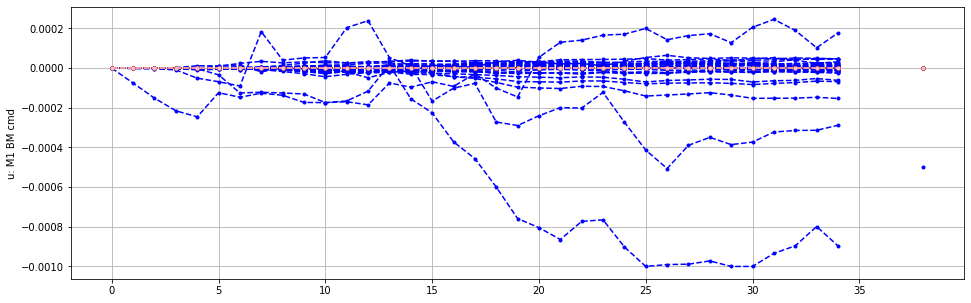

In [8]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [10]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

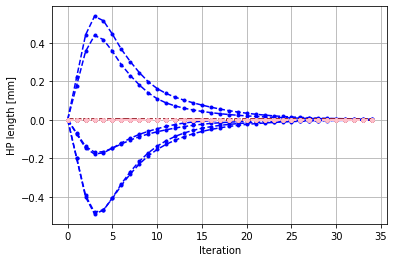

In [29]:
U = sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

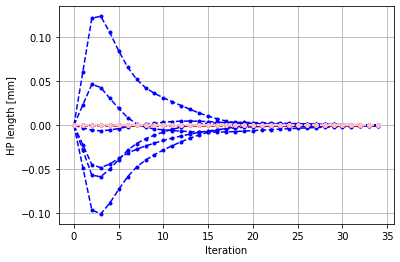

In [11]:
sim.logs.entries['SHAcO']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [79]:
3.5e-6*(180/np.pi)*3600

0.7219268218648373

In [103]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

HP lengths [ 6.15074717  2.42595625  2.38654281  5.98007822  3.34834477 -3.78004005]
HP lengths [ 7.96706706  2.71784883  1.4437542   4.29725283  2.50323777 -2.38093131]


In [98]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

array([[1.84229199e-06, 1.93925472e-04],
       [1.45444104e-05, 1.59988515e-03]])

#### Reconstructed states

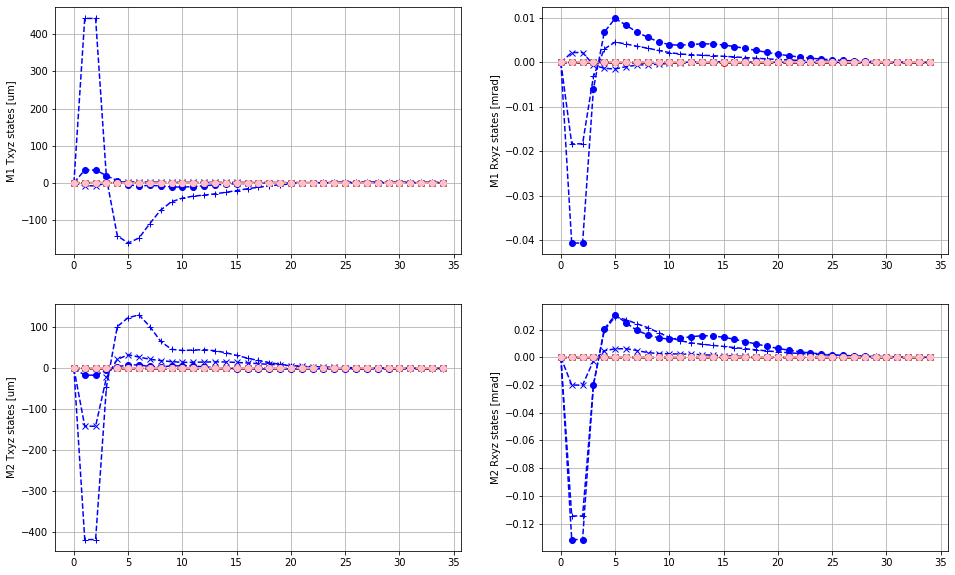

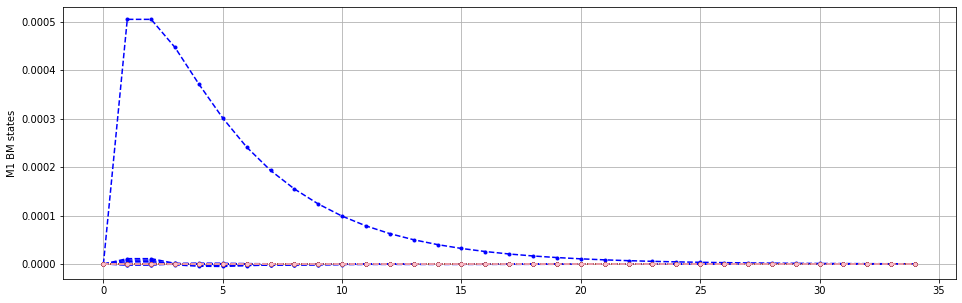

In [12]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

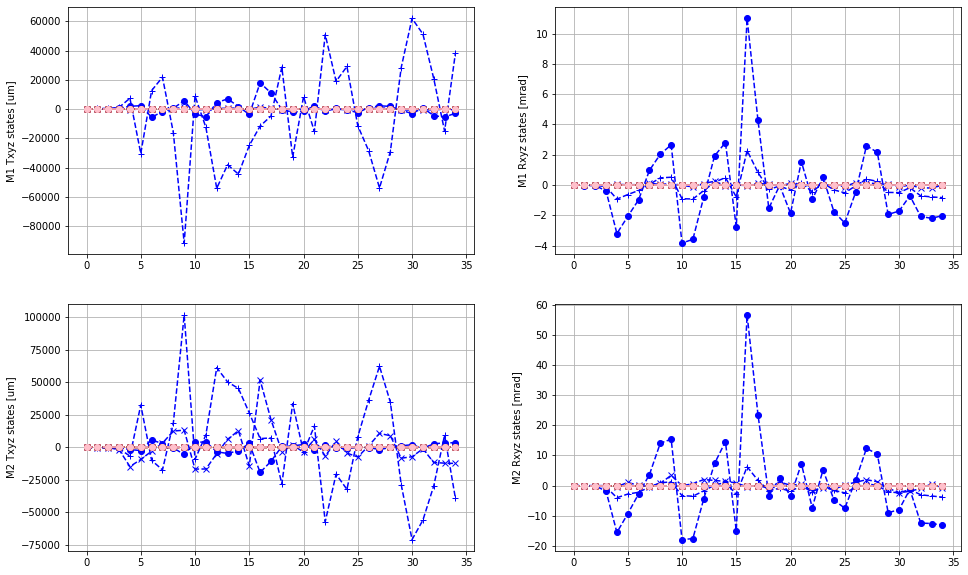

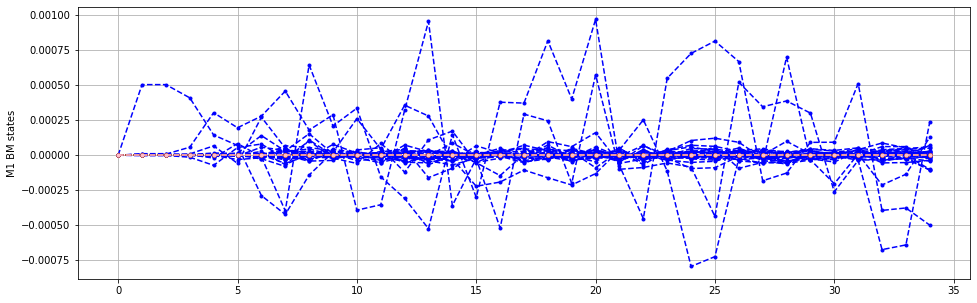

In [9]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

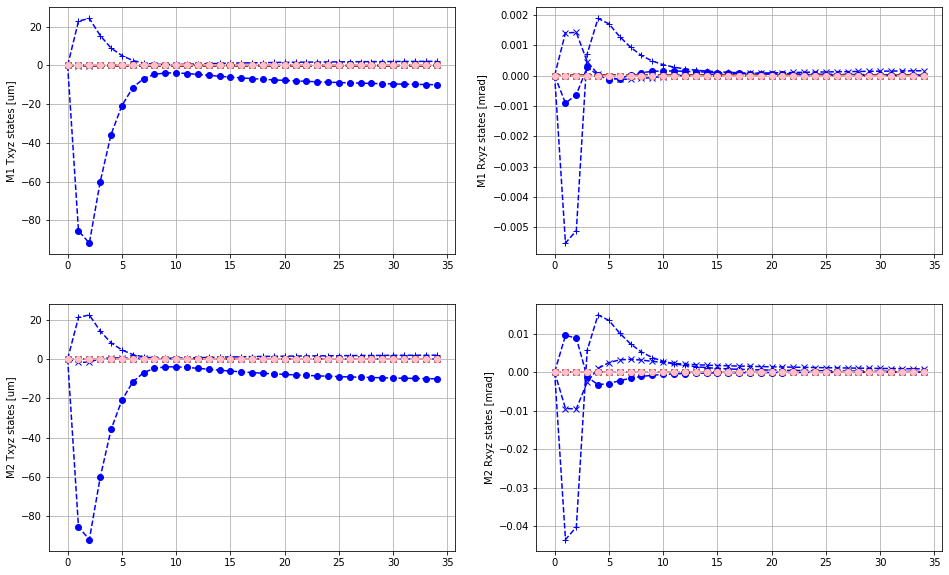

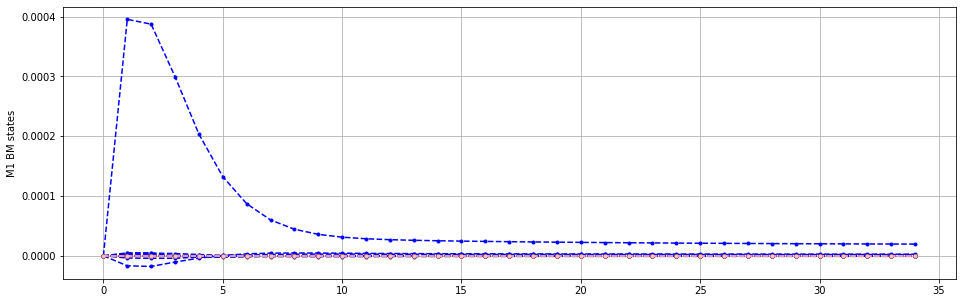

In [21]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

In [9]:
X_timeseries = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries

isample = X_timeseries[0]
# Indices for M1 states
indX = np.reshape(np.arange(X_timeseries[1].shape[1]), [7, 6 + 6 + n_bm])
i1,i2,i3,i4,i5 = np.split(indX,[3, 6, 9, 12], axis=1)

xM1_Txyz = X_timeseries[1][:,np.reshape(i1,[7,3])]
xM1_Rxyz = X_timeseries[1][:,np.reshape(i2,[7,3])]
xM2_Txyz = X_timeseries[1][:,np.reshape(i3,[7,3])]
xM2_Rxyz = X_timeseries[1][:,np.reshape(i4,[7,3])]
xM1_BM = X_timeseries[1][:,np.reshape(i5,[7,n_bm])]

xM1_Txyz.shape

(35, 7, 3)

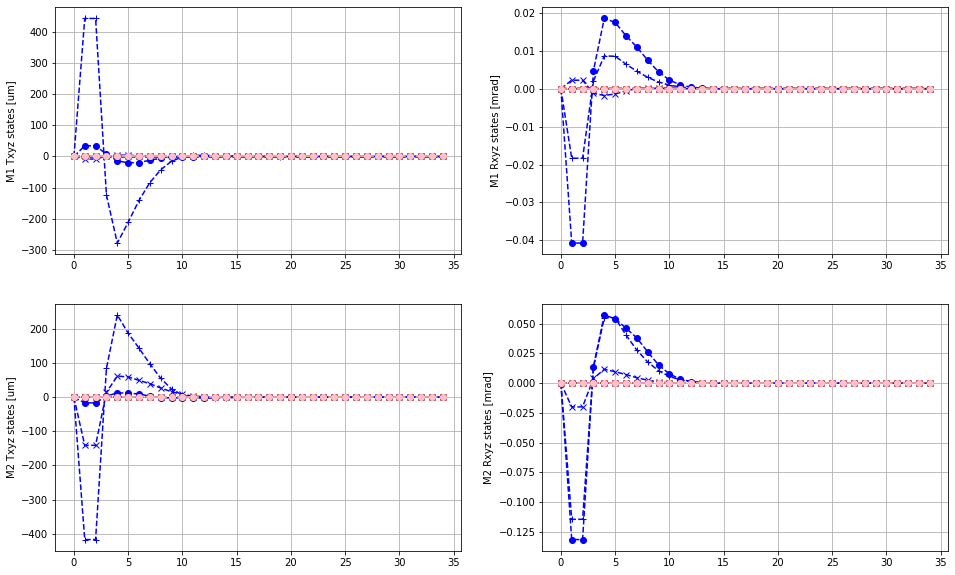

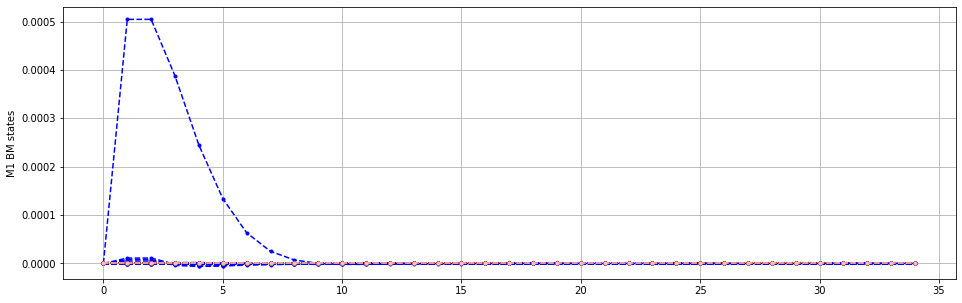

In [10]:
X = sim.logs.entries['SHAcO_debug']['x_hat'].timeSeries
ptools.plot_states(X, n_bm, colors, markers)

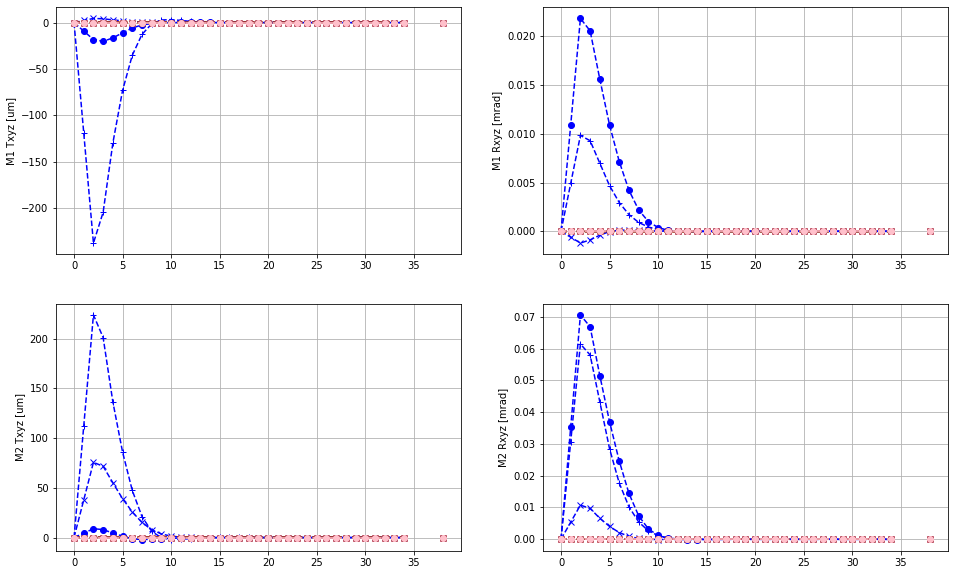

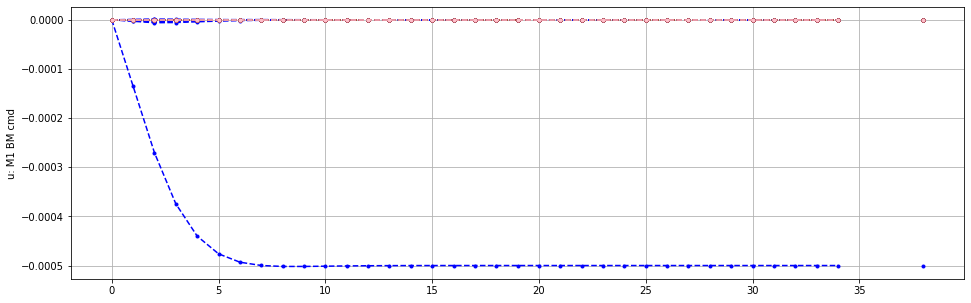

In [8]:
U = sim.logs.entries['SHAcO']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)